# PISA $\pi$ data structure

This notebook will explain the underlying datastructure of PISA $\pi$

## Setup

First, let's set up PISA

In [1]:
# this is to reload source automatically in a jupyter notebook, nothing to do with PISA
%reload_ext autoreload
%autoreload 2

# set some env variables (this would usually be done in your shell or simply skipped)
# you can try out `fp32` or `fp64` precision
# and also `cpu` pr `gpu` target 
import os
os.environ['PISA_FTYPE'] = 'fp32'
os.environ['PISA_TARGET'] = 'gpu'

import numpy as np

# what precision to work in
from pisa import FTYPE

# import some PISA classes
from pisa.core.container import Container, ContainerSet
from pisa.core.map import Map, MapSet
from pisa.core.binning import OneDimBinning, MultiDimBinning

# also import the plotter, since we want to look at some stuff
from pisa.utils.plotter import Plotter
%matplotlib inline
my_plotter = Plotter(log=False)

PISA_FTYPE env var is defined as: "fp32"; PISA running in single precision (FP32) mode.
PISA running on CPU+GPU.


let's create some array data

in pisa pi, data is stored in containers, and several containers live in a ContainerSet

In [2]:
# create an empty ContainerSet
data = ContainerSet(name='data')

# create a container
test1 = Container(name='test1')
# define some random variables
n_events = int(1e6)
test1.add_array_data('energy', np.random.rand(n_events).astype(FTYPE) * 99 + 1)
test1.add_array_data('coszen', np.random.rand(n_events).astype(FTYPE) * 2 - 1)
test1.add_array_data('weight', np.random.rand(n_events).astype(FTYPE))
# add that container into the set
data.add_container(test1)

# let's create one more container
test2 = Container(name='test2')
# define some random variables
n_events = int(1e7)
test2.add_array_data('energy', np.random.rand(n_events).astype(FTYPE) * 99 + 1)
test2.add_array_data('coszen', np.random.rand(n_events).astype(FTYPE) * 2 - 1)
test2.add_array_data('weight', np.random.rand(n_events).astype(FTYPE) ** 2)
# add that container into the set
data.add_container(test2)

The data lives in SmartArrays, which are objects that store the data on the CPU and the GPU (if available)

If we want to acces it, we have to specify from where (i.e. `host` or `gpu`), and when we change sth, we have
to mark it for the automatic update by `.mark_changed(where)`

In [3]:
# for convenience, set the default behavious of the data object to `events`
data.data_specs = 'events'

# example, print out an array in the python prompt (therefore we must access it from the `host`, sicne your promt lives on th CPU, not the GPU)
energy_array = data['test1']['energy'].get('host')

# or change it
energy_array[0] = 17
# don't foget to update!!!
data['test1']['energy'].mark_changed('host')

# the above is just for illustration! We don't wanna do large operations on the data like this, because it is inefficient
# we will need to write a vectorized function (see for examples pisa.utils.vectorizer)

Now we also want to bring binnings into the game

In [4]:
# a quite nice binning
binning_energy = OneDimBinning(name='energy', num_bins=100, is_log=True, domain=[1, 100])
binning_coszen = OneDimBinning(name='coszen', num_bins=100, is_lin=True, domain=[-1, 1])
nice_binning = MultiDimBinning([binning_energy, binning_coszen])

# a different, weird binning
binning_energy = OneDimBinning(name='energy', bin_edges=[1, np.sqrt(2), 2, 3, 7.777, 10*np.pi, 42, 42.2, 66.6, 99.99, 100])
binning_coszen = OneDimBinning(name='coszen', bin_edges=[-1, -0.9, -0.8, -0.666667, -0.0001, 0.0001, 0.3456, 0.57575, 0.8, 0.9, 1])
funny_binning = MultiDimBinning([binning_energy, binning_coszen])

## Translation methods & Computation
Let's translate the array data into binned data, and take a look at that

-> we see that on average the weights in test1 are at 0.5 and in test2 at 0.333..., as expected since the expecation value is $E=0.5$ of uniform random numbers in $(0,1)$ and for its square $E^2 + \frac{1}{12} = 0.333...$

[ WARNING] /home/peller/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



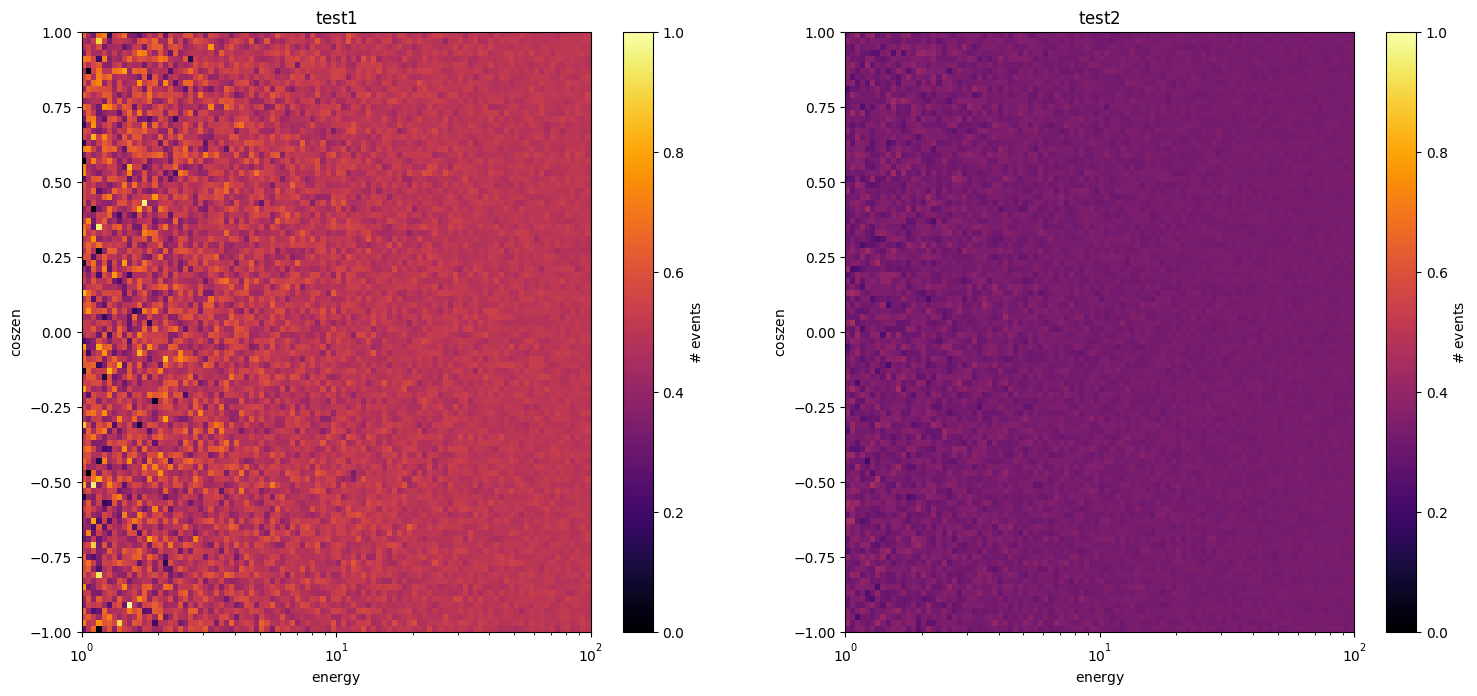

In [5]:
# translate
for container in data:
    container.array_to_binned('weight', nice_binning)

# plot (this will look familiar to you from PISA cake)
maps = data.get_mapset('weight')
my_plotter.plot_2d_array(maps, vmin=0, vmax=1)

Alright, so far so good...
Let's actually compute something

We now want to create a new entry that is twice the weight....let's call it `doubleweight`

This can be calculated event-by-event wise on the array data, or on the binned data. We'll do both and compare....first in event-by-event:

In [6]:
# we do stuff effieceintly on GPU or CPU, therefore we need vectorized functions
from pisa.utils import vectorizer

In [7]:
# tell the data object what mode we're operating in! This `data_specs` can be set to `events` or a binning.
# When this is set, then we can simply access the data with get and set item methods (the square brackets notation)
data.data_specs = 'events'
# construct new entry
for container in data:
    container['doubleweight_from_events'] = np.empty(container.size, dtype=FTYPE)
    vectorizer.scale(2., container['weight'], out=container['doubleweight_from_events'])

[ WARNING] /home/peller/cake/pisa/core/map.py:1500: RuntimeWarning: invalid value encountered in true_divide
  'hist': self.hist / other.hist,



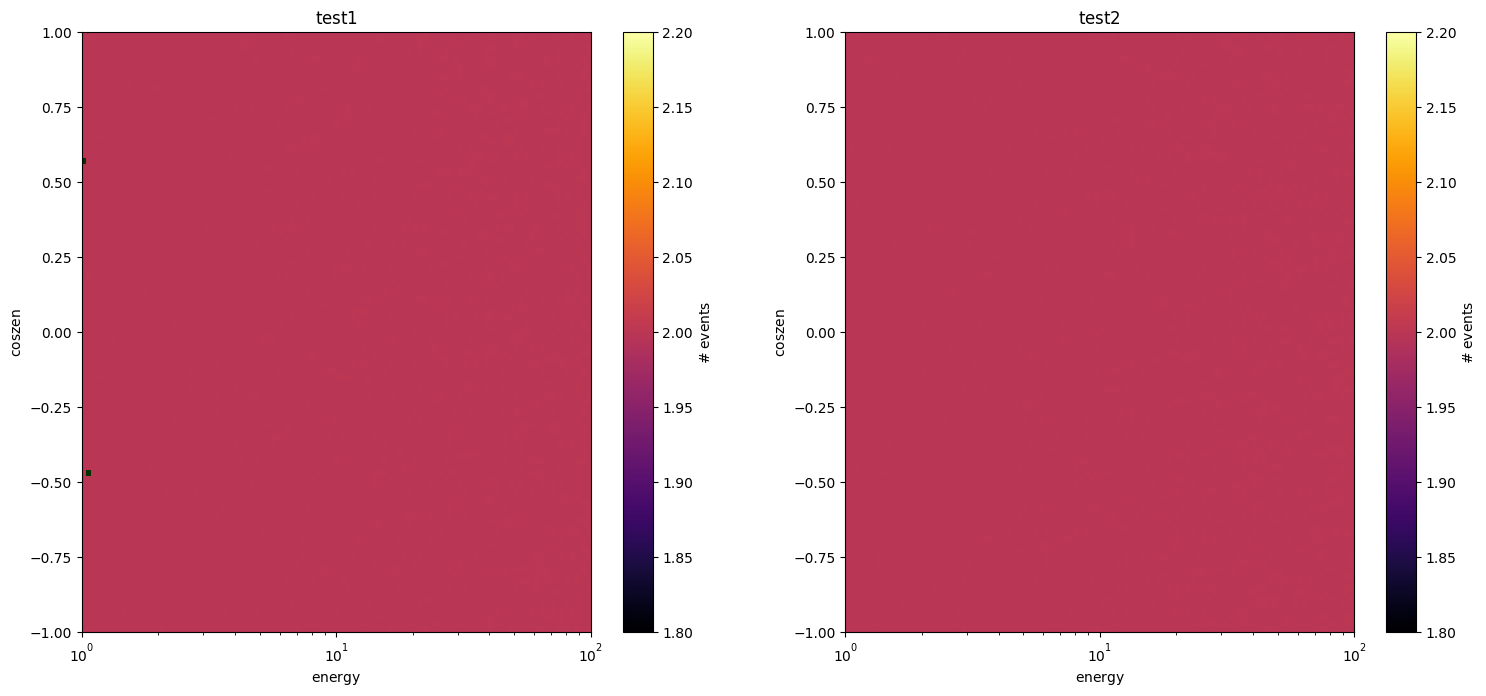

In [8]:
# let's take a look
for container in data:
    container.array_to_binned('doubleweight_from_events', nice_binning)
# plot the ratio
double_maps = data.get_mapset('doubleweight_from_events')
my_plotter.plot_2d_array(double_maps/maps, vmin=1.8, vmax=2.2)

Now let's perform the operation on the binned data

In [9]:
# tell the data object what mode we're operating in!
data.data_specs = nice_binning
# construct new entry (exactly the same logic as before, but the difference is that we have set the `data_specs` to a binning)
# The fact that the operation looks identical is importaat, because we don't need to worry when implementig a method whether
# it will work on array data or on binned data
for container in data:
    container['doubleweight_from_hist'] = np.empty(container.size, dtype=FTYPE)
    vectorizer.scale(2., container['weight'], out=container['doubleweight_from_hist'])

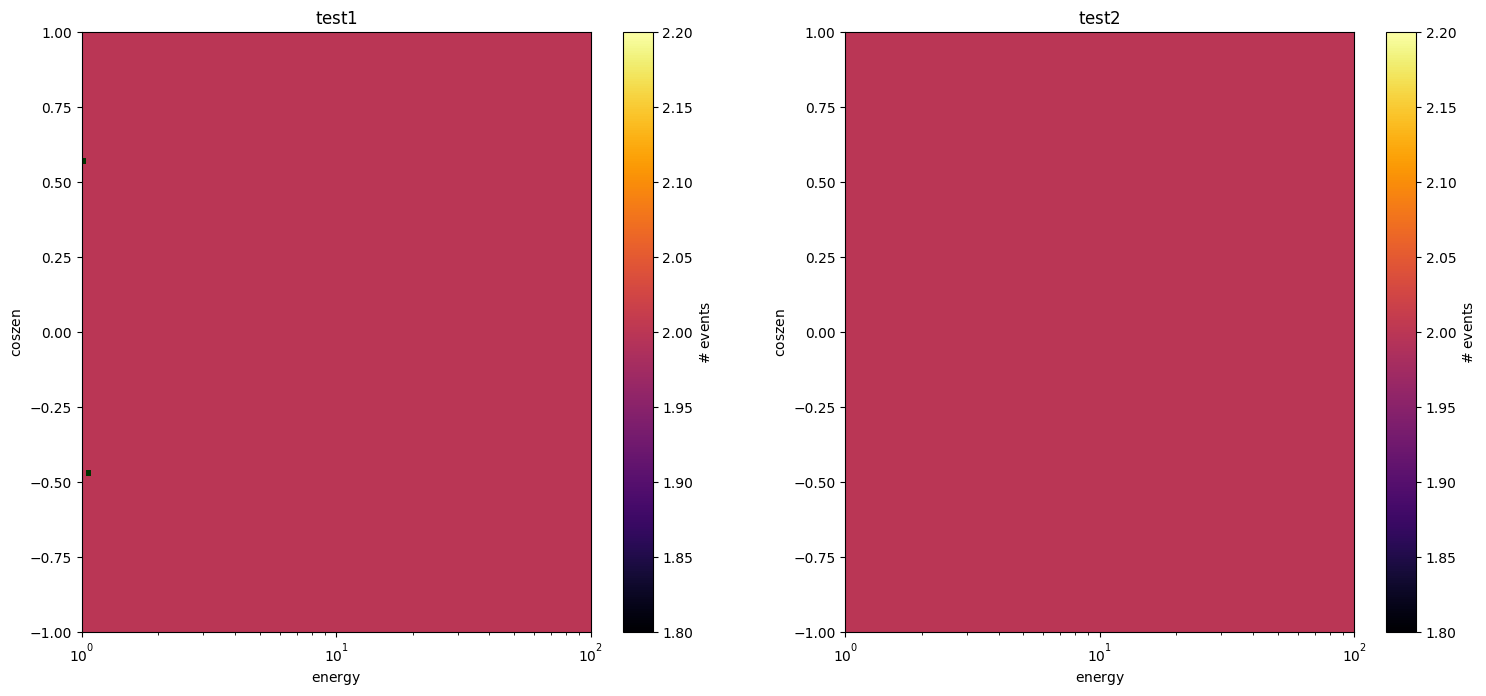

In [10]:
# let's take a look
double_maps = data.get_mapset('doubleweight_from_hist')
my_plotter.plot_2d_array(double_maps/maps, vmin=1.8, vmax=2.2)

What else can we do? Let's suppose we have calculated the `doubleweight` on binned data, but want to put that back into event-by-event info

In [11]:
data.data_specs = 'events'
# translate it!
for container in data:
    container.binned_to_array('doubleweight_from_hist')

In [12]:
# now this probably seems a bit odd, but we can histogram that again!
# it's important to understand what happens here
# we calculate a quantity on binned data and translate it back to event-by-event level
for container in data:
    container.array_to_binned('doubleweight_from_hist', nice_binning)

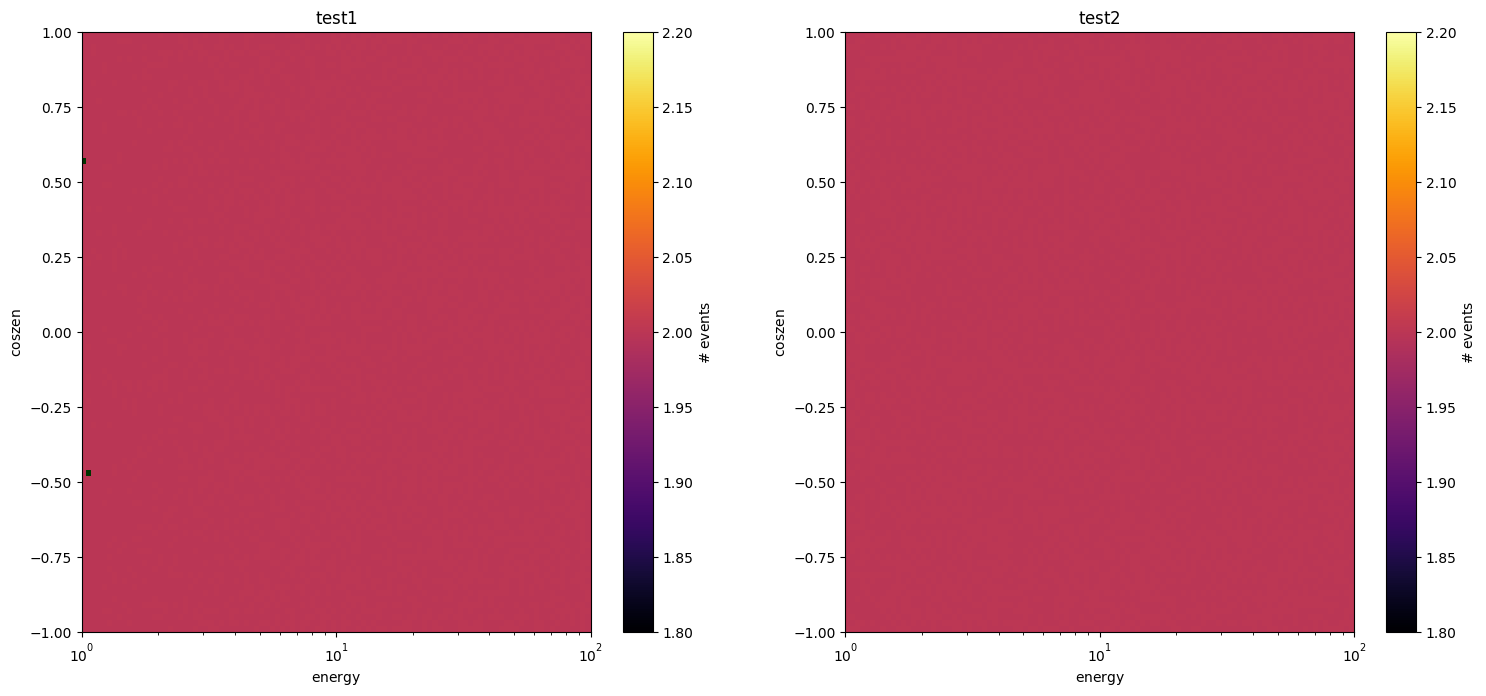

In [13]:
# let's take a look again
double_maps = data.get_mapset('doubleweight_from_hist')
my_plotter.plot_2d_array(double_maps/maps, vmin=1.8, vmax=2.2)

So doesn't this mean we did the same thing? *NO!*
Let's take a closer look at what we actually calculated on an event-by-event basis

In [14]:
# the original weight was
print data['test1']['weight'].get('host')

[ 0.01748073  0.24048097  0.09610263 ...,  0.33883819  0.81174052
  0.09885865]


In [15]:
# then we doubled that (and of courseevery entry is exactly double)
print data['test1']['doubleweight_from_events'].get('host')

[ 0.03496146  0.48096195  0.19220525 ...,  0.67767638  1.62348104
  0.19771729]


In [16]:
# but then we doubled that based on a histogram, and therefore must loose some information!
# these number look quite different! 
print data['test1']['doubleweight_from_hist'].get('host')

[ 1.0213939   0.97380883  0.98432845 ...,  0.96676016  0.99484128
  1.09078074]


In [17]:
# Only on average they are the same
with np.errstate(divide='ignore', invalid='ignore'):
    ratio =  data['test1']['doubleweight_from_events'].get('host') / data['test1']['doubleweight_from_hist'].get('host')
print 'ratio ',ratio
print 'mean ratio = %.10f'%np.ma.masked_invalid(ratio).mean()
# the finer the binning, the better the approximation (play arround with it)

ratio  [ 0.03422916  0.49389771  0.19526537 ...,  0.70097673  1.6318996
  0.18126218]
mean ratio = 0.9999998750


So, we learned how to translate from arrays to binned data and back
Let's try to ranslate between different binnings

[ WARNING] Automatically re-beinning data weight
[ WARNING] Automatically re-beinning data weight


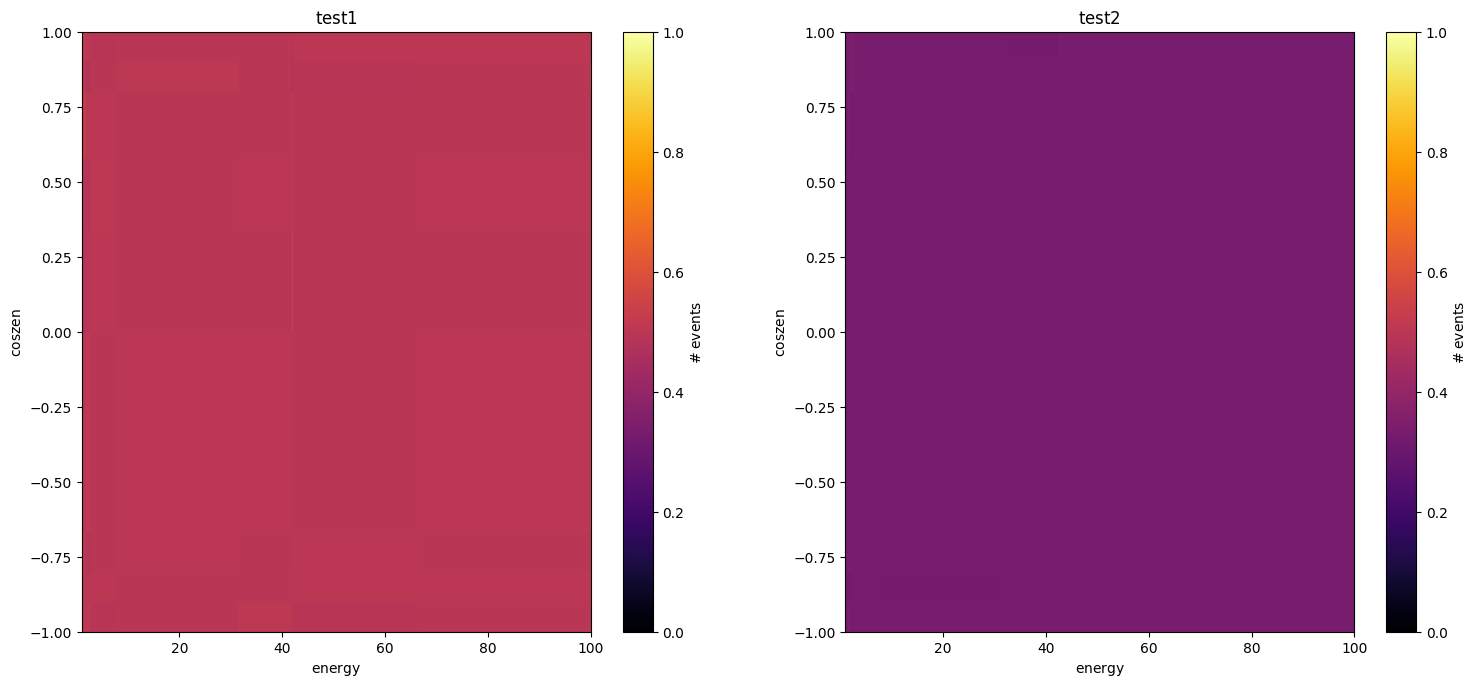

In [18]:
# does work without explicit translations
data.data_specs=funny_binning
new_maps = data.get_mapset('weight')
my_plotter.plot_2d_array(new_maps, vmin=0, vmax=1)

What if we did that starting from events?

In [19]:
data.data_specs = 'events'
for container in data:
    container.array_to_binned('weight', funny_binning)

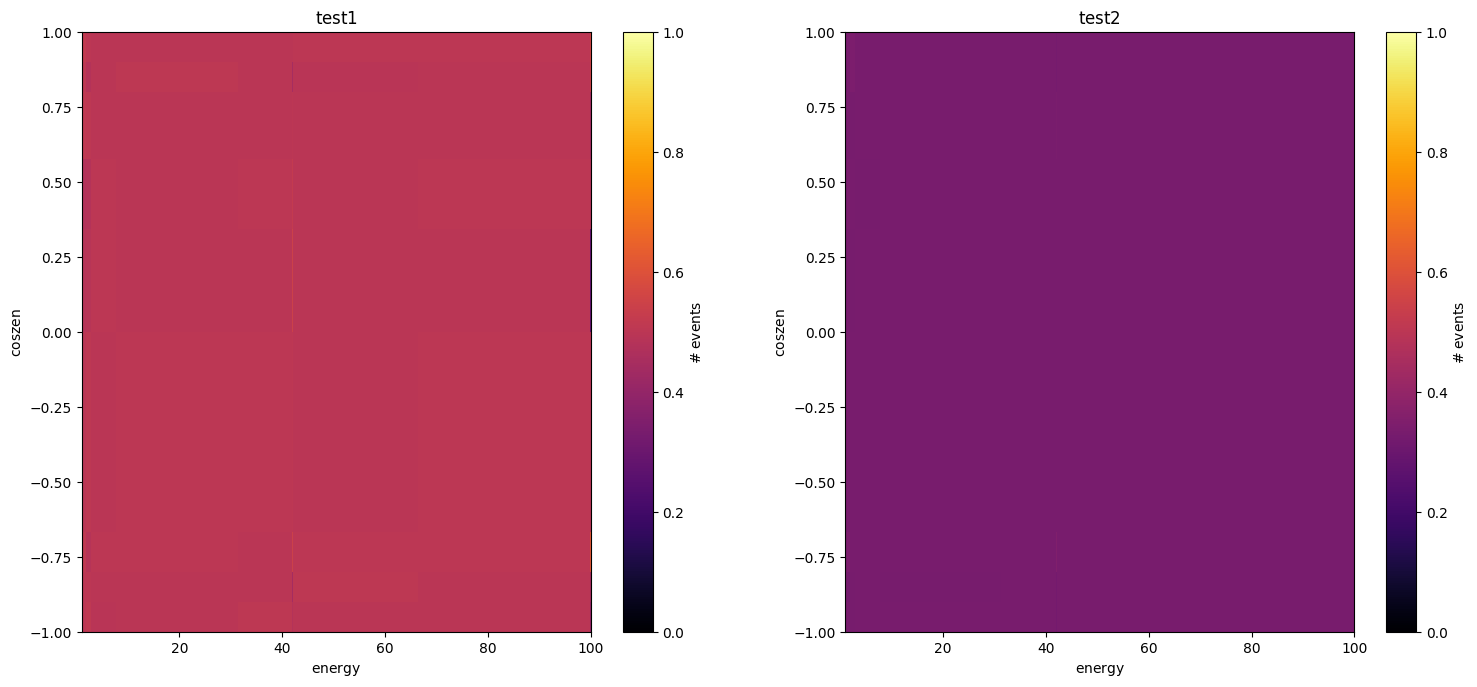

In [20]:
new_maps = data.get_mapset('weight')
my_plotter.plot_2d_array(new_maps, vmin=0, vmax=1)

Of course not exactly the same, as we lost a lot of information in the first approach going through different binnings...

We can even traslate back to the first binning if we wanted to:

In [21]:
data.data_specs = funny_binning
for container in data:
    container.binned_to_binned('weight', nice_binning)

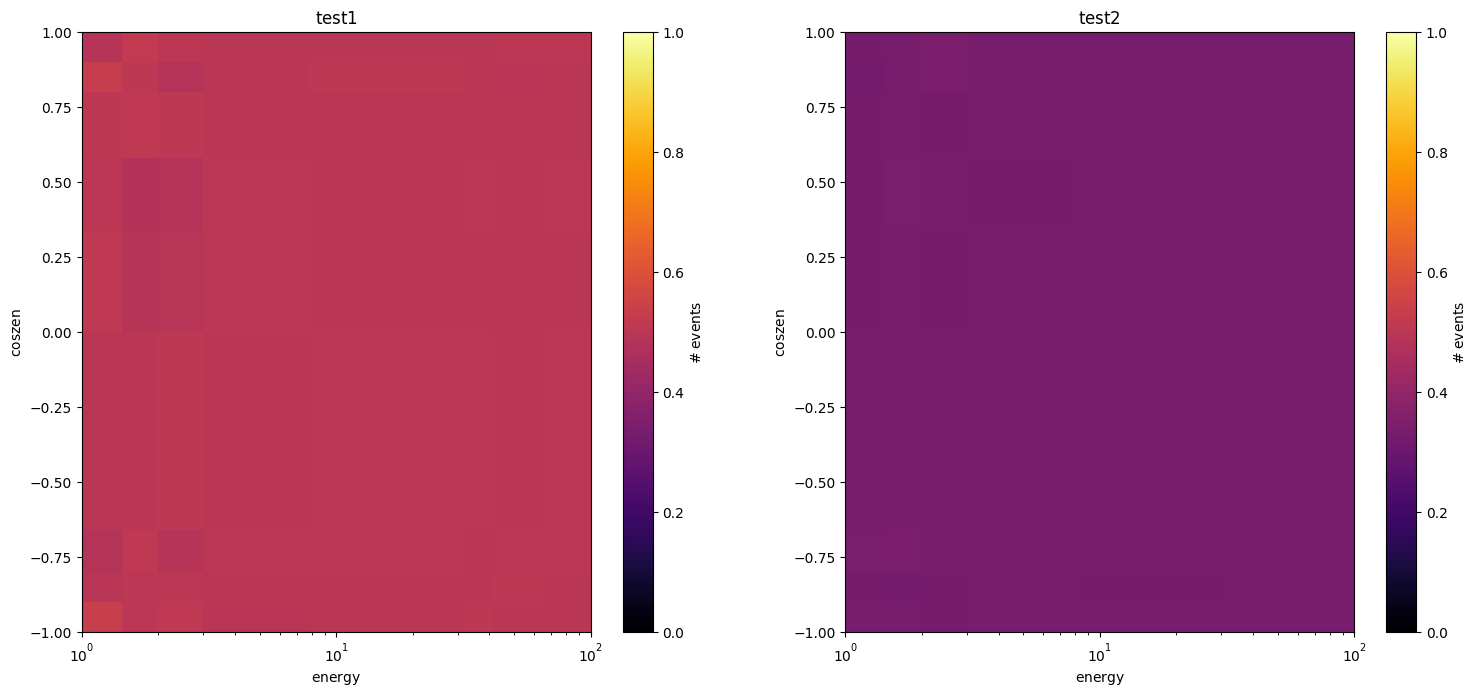

In [22]:
data.data_specs = nice_binning
new_maps = data.get_mapset('weight')
my_plotter.plot_2d_array(new_maps, vmin=0, vmax=1)

## Some more fun

In [23]:
import matplotlib.pyplot as plt
from matplotlib.cbook import get_sample_data
fn = get_sample_data("grace_hopper.png", asfileobj=False)
img = plt.imread(fn, format='png')
img = img.astype(FTYPE)

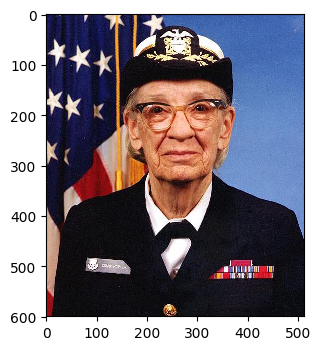

In [24]:
plt.imshow(img)

In [86]:
# binnign for the test data
binning_x = OneDimBinning(name='x', bin_edges=np.linspace(0,1,img.shape[0]+1).astype(FTYPE))
binning_y = OneDimBinning(name='y', bin_edges=np.linspace(0,1,img.shape[1]+1).astype(FTYPE))
img_binning = MultiDimBinning([binning_x, binning_y])

In [87]:
# create a container
test3 = Container(name='test1')
# define some random variables
test3.add_binned_data('img_rgb', (img_binning, img), flat=False)

In [97]:
# new binnign for the test data
x = np.cumsum(np.random.rand(301))
x /= x[-1]
y = np.cumsum(np.random.rand(257))
y /= y[-1]
binning_x = OneDimBinning(name='x', bin_edges=x.astype(FTYPE))
binning_y = OneDimBinning(name='y', bin_edges=y.astype(FTYPE))
new_img_binning = MultiDimBinning([binning_x, binning_y])

In [98]:
test3.data_specs = new_img_binning
img2 = test3.get_hist('img_rgb')

[ WARNING] Automatically re-beinning data img_rgb


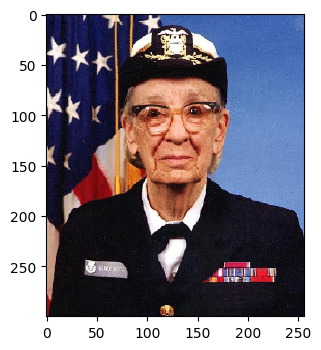

In [99]:
# try it, it looks funny every time
plt.imshow(img2[0])

In [77]:
# wanna know how does the square root of the original image look like?
test3.data_specs = img_binning
test3['sqrt_img'] = np.empty((test3.size,3), dtype=FTYPE)

In [78]:
vectorizer.sqrt(test3['img_rgb'], out=test3['sqrt_img'])

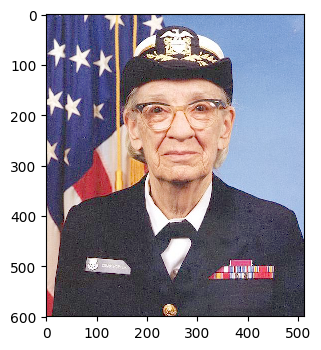

In [43]:
img3 = test3.get_hist('sqrt_img')
plt.imshow(img3[0])